In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from algo import AdaFair, AdaBoost, SMOTEBoost

from utils import get_dataset
from metrics import calculate_metrics

In [4]:
dataset_list = [
    'adult',
    'bank',
    'compass',
    'kdd',
]
algorithms = [
    AdaBoost,
    AdaFair,
#     SMOTEBoost
]
train_metrics, test_metrics = {}, {}

for dataset in tqdm(dataset_list):
    print(f'Dataset {dataset}')
    
    X_train, y_train, is_protected_train, X_test, y_test, is_protected_test = get_dataset(dataset)
    
    print(f'Train size: {X_train.shape}, Test size: {X_test.shape}')
    print(f'Positive ratio (train): {y_train.mean():.3f}, Positive ratio (test): {y_test.mean():.3f}')
    print(f'Protected ratio (train): {is_protected_train.mean():.3f}, Protected ratio (test): {is_protected_test.mean():.3f}')
    
    for model_class in algorithms:
        model = model_class()
        model.fit(X_train, y_train, is_protected_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_metrics[dataset, model_class.__name__] = calculate_metrics(y_train, y_train_pred, is_protected_train)
        test_metrics[dataset, model_class.__name__] = calculate_metrics(y_test, y_test_pred, is_protected_test)
    
    print()

  0%|          | 0/4 [00:00<?, ?it/s]

Dataset adult
Train size: (32561, 108), Test size: (16281, 108)
Positive ratio (train): 0.241, Positive ratio (test): 0.236
Protected ratio (train): 0.331, Protected ratio (test): 0.333

Dataset bank
Train size: (33908, 51), Test size: (11303, 51)
Positive ratio (train): 0.117, Positive ratio (test): 0.117
Protected ratio (train): 0.602, Protected ratio (test): 0.602

Dataset compass
Train size: (4629, 11), Test size: (1543, 11)
Positive ratio (train): 0.455, Positive ratio (test): 0.455
Protected ratio (train): 0.190, Protected ratio (test): 0.191

Dataset kdd
Train size: (199523, 409), Test size: (99762, 409)
Positive ratio (train): 0.062, Positive ratio (test): 0.062
Protected ratio (train): 0.521, Protected ratio (test): 0.519



In [5]:
test_metrics

{('adult', 'AdaBoost'): {'Accuracy': 0.8602665683926048,
  'Bal. Acc.': 0.7741893415181722,
  'Eq.Odds': 0.1900952659957882,
  'TPR Prot.': 0.5101694915254237,
  'TPR Non-Prot.': 0.6292997542997543,
  'TNR Prot.': 0.9807493272614366,
  'TNR Non-Prot.': 0.909784324039979},
 ('adult', 'AdaFair'): {'Accuracy': 0.8089183711074258,
  'Bal. Acc.': 0.8054971342400137,
  'Eq.Odds': 0.47783078276380586,
  'TPR Prot.': 0.5966101694915255,
  'TPR Non-Prot.': 0.8356879606879607,
  'TNR Prot.': 0.9579797143448562,
  'TNR Non-Prot.': 0.7192267227774856},
 ('bank', 'AdaBoost'): {'Accuracy': 0.8961337697956295,
  'Bal. Acc.': 0.6665521146759782,
  'Eq.Odds': 0.09766276220003889,
  'TPR Prot.': 0.3309143686502177,
  'TPR Non-Prot.': 0.4060031595576619,
  'TNR Prot.': 0.9749795584627964,
  'TNR Non-Prot.': 0.9524055871702017},
 ('bank', 'AdaFair'): {'Accuracy': 0.8639299301070512,
  'Bal. Acc.': 0.7943307109529285,
  'Eq.Odds': 0.03835162207213749,
  'TPR Prot.': 0.6966618287373004,
  'TPR Non-Prot.': 0

test metrics:


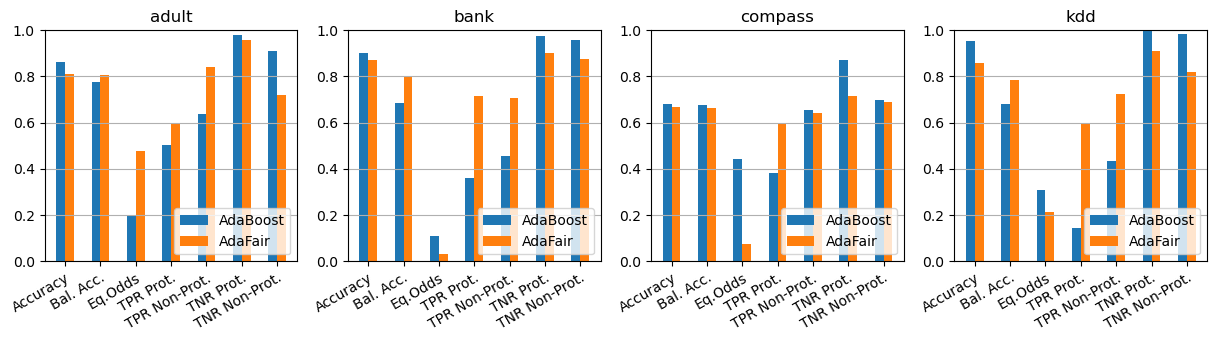

train metrics:


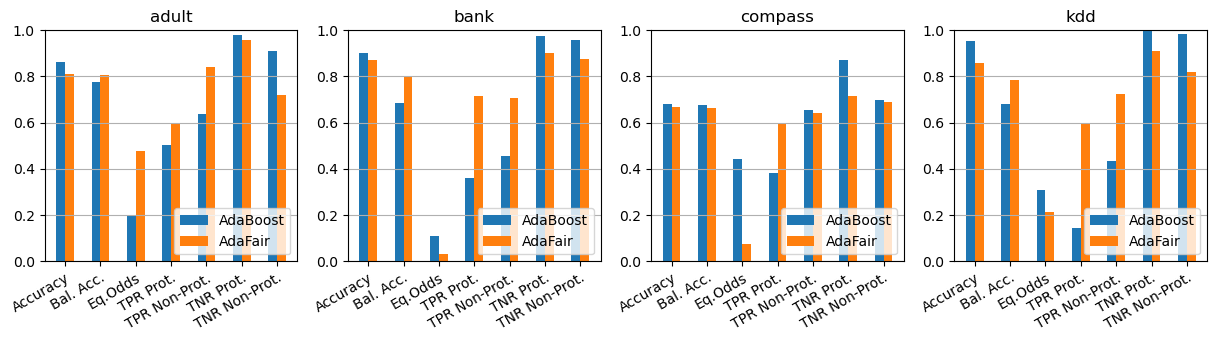

In [8]:
def plot_metrics(ax, metrics, dataset):
    metric_names = metrics[dataset, algorithms[0].__name__].keys()
    x = np.arange(len(metric_names))
    width = 0.25  # the width of the bars
    ax.yaxis.grid()
    for i, algo in enumerate(algorithms):
        algo_name = algo.__name__
        measurement = [metrics[dataset, algo_name][m] for m in metric_names]
        rects = ax.bar(x + width * i, measurement, width, label=algo_name)
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')
    ax.set_xticks(x + width * (len(algorithms) - 1) / 2, metric_names, rotation=30,
                  rotation_mode="anchor", horizontalalignment='right', verticalalignment='top')

for metrics, name in [(test_metrics, 'test'), (train_metrics, 'train')]:
    _, axes = plt.subplots(1, len(dataset_list), figsize=(15, 3))
    if len(dataset_list) == 1:
        axes = [axes]
    print(name, 'metrics:')
    for dataset, ax in zip(dataset_list, axes):
        plot_metrics(ax, train_metrics, dataset)
        ax.set_title(dataset)
    plt.show()